# Scikit-learn Integration with JAXSR

JAXSR estimators implement the scikit-learn estimator protocol (`get_params`, `set_params`),
enabling seamless use with sklearn's meta-tools: `clone`, `cross_val_score`, `GridSearchCV`,
and `Pipeline`.

This notebook demonstrates these integrations with a synthetic dataset.

In [9]:
import numpy as np
from jaxsr import BasisLibrary, SymbolicRegressor, MultiOutputSymbolicRegressor

## Setup: Synthetic Data

In [10]:
rng = np.random.default_rng(42)# Note: Using modern default_rng() instead of deprecated RandomState()X = rng.randn(100, 2)y = 2.0 * X[:, 0] + 3.0 * X[:, 1] ** 2 + 0.1 * rng.randn(100)library = (    BasisLibrary(n_features=2)    .add_constant()    .add_linear()    .add_polynomials(max_degree=3))print(f"Data: {X.shape[0]} samples, {X.shape[1]} features")print(f"Basis library: {len(library)} candidate terms")

## 1. `get_params` / `set_params` / `clone` Basics

In [11]:
model = SymbolicRegressor(basis_library=library, max_terms=5)

# Inspect parameters
params = model.get_params(deep=False)
print("Parameters:")
for k, v in sorted(params.items()):
    print(f"  {k}: {v!r}")

Parameters:
  basis_library: BasisLibrary(n_features=2, n_basis=7, feature_names=['x0', 'x1'])

Basis functions:
  [   0] 1                                        (complexity=0)
  [   1] x0                                       (complexity=1)
  [   2] x1                                       (complexity=1)
  [   3] x0^2                                     (complexity=2)
  [   4] x0^3                                     (complexity=3)
  [   5] x1^2                                     (complexity=2)
  [   6] x1^3                                     (complexity=3)
  constraint_enforcement: 'penalty'
  constraints: None
  cv_folds: 5
  information_criterion: 'bic'
  max_terms: 5
  param_optimization_budget: 50
  param_optimizer: 'scipy'
  random_state: None
  regularization: None
  strategy: 'greedy_forward'


In [12]:
# Modify parameters
model.set_params(max_terms=3, strategy="exhaustive")
print(f"max_terms = {model.max_terms}")
print(f"strategy  = {model.strategy}")

max_terms = 3
strategy  = exhaustive


In [13]:
from sklearn.base import clone

model = SymbolicRegressor(basis_library=library, max_terms=5)
model_copy = clone(model)
print(f"Original:  {model}")
print(f"Clone:     {model_copy}")
print(f"Same type: {type(model_copy).__name__}")

Original:  SymbolicRegressor(max_terms=5, strategy='greedy_forward', not fitted)
Clone:     SymbolicRegressor(max_terms=5, strategy='greedy_forward', not fitted)
Same type: SymbolicRegressor


## 2. Cross-Validation with `cross_val_score`

In [14]:
from sklearn.model_selection import cross_val_score

model = SymbolicRegressor(basis_library=library, max_terms=5)
scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print(f"R² scores: {scores}")
print(f"R² = {scores.mean():.3f} ± {scores.std():.3f}")

R² scores: [0.99926339 0.99917149 0.99939025 0.99926731 0.99968605]
R² = 0.999 ± 0.000


## 3. Hyperparameter Tuning with `GridSearchCV`

In [15]:
from sklearn.model_selection import GridSearchCV

model = SymbolicRegressor(basis_library=library)

param_grid = {
    "max_terms": [2, 3, 5],
    "information_criterion": ["aic", "bic"],
}

grid = GridSearchCV(model, param_grid, cv=3, scoring="r2", n_jobs=1)
grid.fit(X, y)

print(f"Best params: {grid.best_params_}")
print(f"Best R²: {grid.best_score_:.3f}")
print(f"Best expression: {grid.best_estimator_.expression_}")

Best params: {'information_criterion': 'aic', 'max_terms': 3}
Best R²: 0.999
Best expression: y = 3.003*x1^2 + 2.017*x0 - 0.005563*x1^3


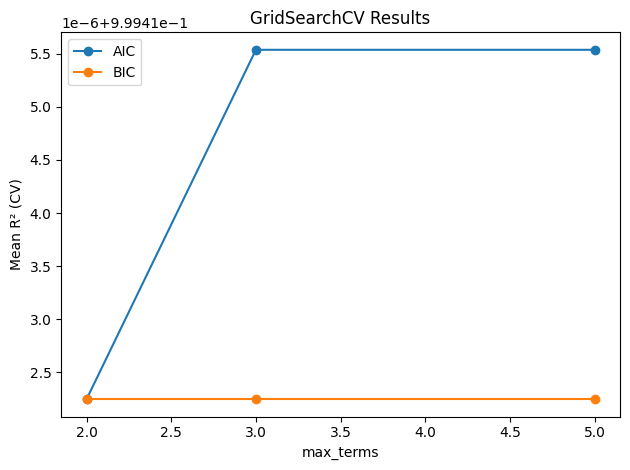

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

results = pd.DataFrame(grid.cv_results_)
for ic in ["aic", "bic"]:
    subset = results[results["param_information_criterion"] == ic]
    plt.plot(
        subset["param_max_terms"],
        subset["mean_test_score"],
        "o-",
        label=ic.upper(),
    )

plt.xlabel("max_terms")
plt.ylabel("Mean R² (CV)")
plt.title("GridSearchCV Results")
plt.legend()
plt.tight_layout()
plt.show()

## 4. Pipeline with Preprocessing

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("sr", SymbolicRegressor(basis_library=library, max_terms=5)),
])

pipe.fit(X, y)
y_pred = pipe.predict(X)

r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - y.mean()) ** 2)
print(f"Pipeline R²: {r2:.3f}")
print(f"Expression (on scaled features): {pipe.named_steps['sr'].expression_}")

Pipeline R²: 0.999
Expression (on scaled features): y = 2.958*x1^2 + 1.721*x0 + 0.1868*x1 - 0.216


## 5. Model Comparison: JAXSR vs sklearn Regressors

In [18]:
from sklearn.linear_model import Lasso, LinearRegression

models = {
    "LinearRegression": LinearRegression(),
    "Lasso(alpha=0.1)": Lasso(alpha=0.1),
    "SymbolicRegressor": SymbolicRegressor(basis_library=library, max_terms=5),
}

print(f"{'Model':30s}  {'R² (mean ± std)':20s}")
print("-" * 55)
for name, m in models.items():
    scores = cross_val_score(m, X, y, cv=5, scoring="r2")
    print(f"{name:30s}  {scores.mean():.3f} ± {scores.std():.3f}")

Model                           R² (mean ± std)     
-------------------------------------------------------
LinearRegression                0.180 ± 0.150
Lasso(alpha=0.1)                0.181 ± 0.143
SymbolicRegressor               0.999 ± 0.000


## 6. MultiOutputSymbolicRegressor with sklearn CV

In [19]:
Y = np.column_stack([
    2.0 * X[:, 0] + 0.1 * rng.randn(100),
    3.0 * X[:, 1] ** 2 + 0.1 * rng.randn(100),
])

template = SymbolicRegressor(basis_library=library, max_terms=4)
mo = MultiOutputSymbolicRegressor(estimator=template)

# Nested parameter access
print(f"estimator__max_terms = {mo.get_params()['estimator__max_terms']}")

# Cross-validate
scores = cross_val_score(mo, X, Y, cv=3, scoring="r2")
print(f"Multi-output R² = {scores.mean():.3f} ± {scores.std():.3f}")

estimator__max_terms = 4
Multi-output R² = 0.998 ± 0.001
